# SVM

## Lineal

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons


from sklearn.svm import SVC as svm
import matplotlib.pyplot as plt
import numpy as np

import itertools

### Empram un conjunt de dades artificial (I)

Com hem anat fent fins ara empram un conjunt de dades sintètiques per veure l'efecte de les diferents tècniques utilitzades.

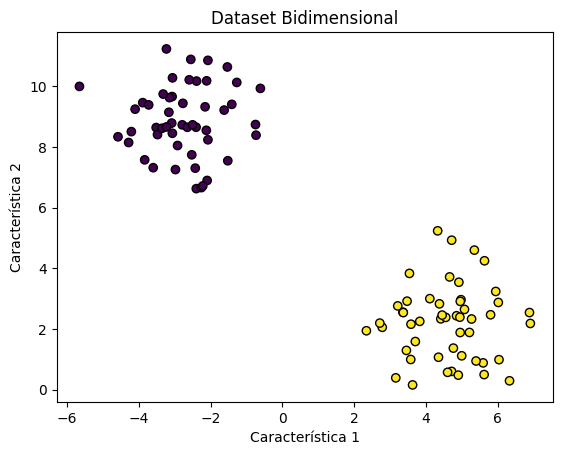

In [2]:
# Generació del dataset
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.2, random_state=42)

# Visualització del dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Dataset Bidimensional")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

### Entrenament

A la sessió d'avui introduïrem com emprar hiperparàmetres i com seleccionar els seus millors valors. Per saber els hiperparàmetres de cada un d'ells una manera simple és emprar la respectiva plana de ``scikit-learn``. En el següent [enllaç](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) trobareu els hiperparàmetres de ``SVM``. **Alerta:** avui emprarem una versió lineal per aquest motiu molts d'ells no tenen sentit. En discutirem a la següent sessió.

In [3]:
def plot_svm_decision_boundary(model, X, y, titol = None):
    """ Dibuixa la regió de decisió del model.

    Alerta:
        Codi més enllà de l'objectiu de l'assignatura. No és necessari
        comprendre el que fa. Creat amb l'ajuda de ChatGPT.

    Args:
        model: Model a pintar.
        X (np.array): Dades d'entrada.
        y (np.array): Dades de predicció.
        titol (str): Opcional, títol del gràfic. Si nó s'indica mostra
            el títol per defecte.

    Returns:
        None
    """
    if titol is None:
        titol = "Regions de Decisió"

    # Crear un meshgrid
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 500),
                         np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Dibuixar l'hiperplà i els marges
    plt.contourf(xx, yy, Z > 0, alpha=0.6, cmap='coolwarm')
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title(titol)
    plt.show()

#### Efecte del hiperparàmetre $C$

Dades sense outliers.

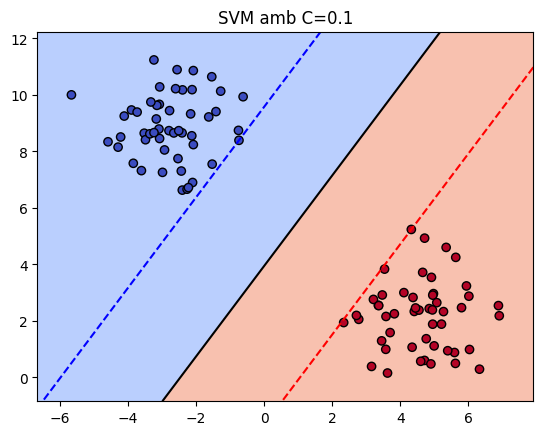

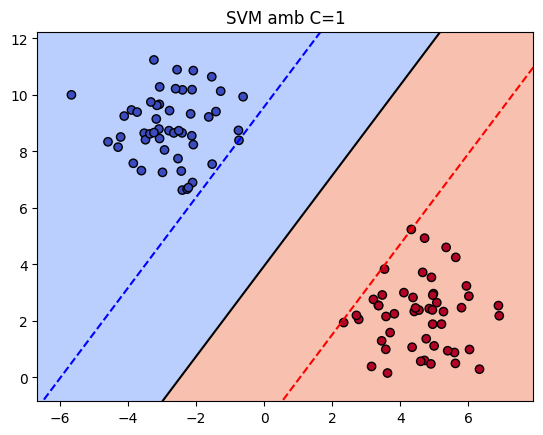

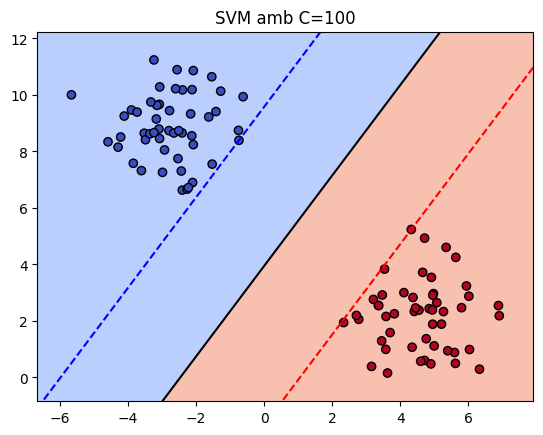

In [4]:
# Provar diferents valors de C
C_values = [0.1, 1, 100]
models = []
for C in C_values:
    model = svm(kernel='linear', C=C)
    model.fit(X, y)
    models.append(model)

    # Visualitzar la decisió
    plot_svm_decision_boundary(model, X, y, f"SVM amb C={C}")


Dades amb *outliers*

In [5]:
# Afegir un outlier
X = np.vstack([X, [8, 8]])
y = np.concat((y, [0]))


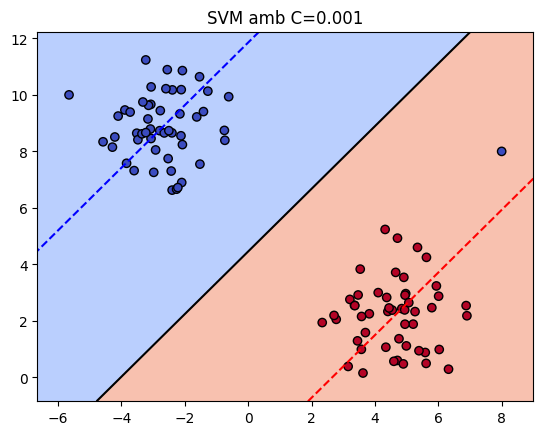

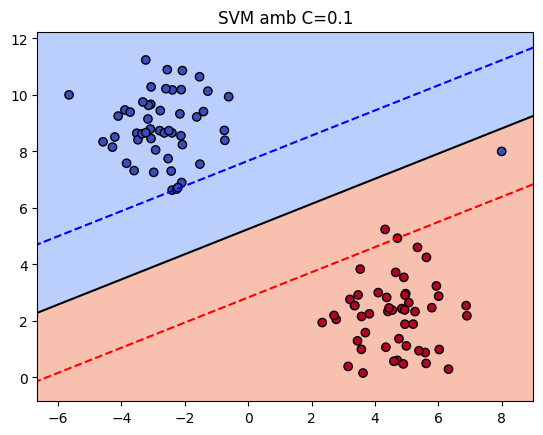

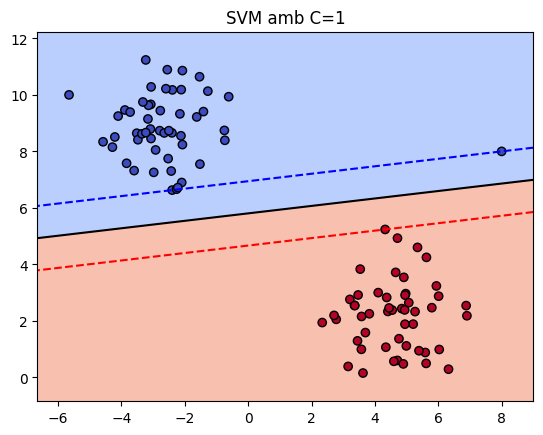

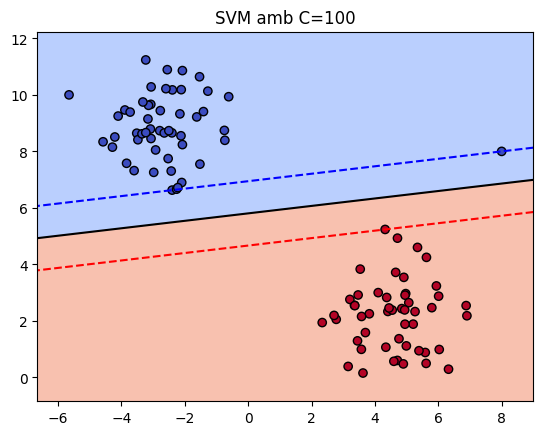

In [6]:
# Provar diferents valors de C
C_values = [0.001, 0.1, 1, 100]
models = []
for C in C_values:
    model = svm(kernel='linear', C=C)
    model.fit(X, y)
    models.append(model)

    # Visualitzar la decisió
    plot_svm_decision_boundary(model, X, y, f"SVM amb C={C}")

## Interpretació de les gràfiques i la importància de $C$

En les gràfiques, observem l'efecte del paràmetre $C$ sobre el comportament d'un SVM lineal:

- Hiperplà de decisió (línia negra): és la frontera que separa les dues classes.
- Marges (línies discontínues): delimiten la zona més propera a l'hiperplà. Els punts que es troben sobre aquestes línies són els vectors de suport, que determinen la posició de l'hiperplà.
- Distribució dels punts: veiem com el model gestiona punts dins del marge o mal classificats segons el valor de CC.

### Efecte del hiperparàmetre $C$

* $C$ petit:
    - Permet més errors (punt mal classificats o dins del marge).
    - Resulta en un marge més ample, amb un model que prioritza la generalització sobre l'ajust precís a les dades d'entrenament.
* $C$ gran:
    - Penalitza fortament els errors, forçant el model a classificar correctament gairebé tots els punts.
    - Això redueix el marge i pot conduir a sobreajustament (overfitting), especialment en presència de soroll o outliers.

Un valor adequat de $C$ és crític per aconseguir un bon equilibri entre generalització i precisió en l'entrenament. Un valor massa petit pot portar a un model infraajustat (underfitting), mentre que un valor massa gran pot conduir a sobreajustament (overfitting).

## Millor hiperparàmetres

En l'entrenament de models d'aprenentatge automàtic, un hiperparàmetre és qualsevol paràmetre que no s'aprèn directament durant el procés d'entrenament, sinó que s'ha de definir abans d'entrenar el model. Aquests paràmetres són configuracions que influeixen en el comportament del model, com també en la seva capacitat per aprendre i generalitzar sobre nous conjunts de dades.

A diferència dels paràmetres que es determinen durant l'entrenament del model (com els pesos en una xarxa neuronal), els hiperparàmetres han de ser configurats prèviament, normalment a partir de l'experiència del dissenyador del model, assaig i error, o mitjançant tècniques de cerca.

Nosaltres emprarem una cerca exhaustiva, és a dir, provarem tot un conjunt de configuracions i seleccionarem la millor. Tot seguit teniu una implementació que dur a terme aquesta tasca. Per fer-ho empram un producte cartesià i comprovam quin té la millor accuracy. A més empram ``cross validation`` per tenir uns millors estimadors.

En el cas de l'**SVM** tenim, per ara, un únic hiperparàmetre $C$.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
def cross_validate(model, X, y, k=5, mesura = None):
    """ Funció extreta de l'anterior sessió.

    Args:
        model (sklearn.model): Model a testejar no instanciat.
        X (np.array): Dades d'entrada.
        y (np.array): Dades de predicció.
        k: K-fold cross validation parameter.
        mesura (function): Funció de mesura, si nó es passa per paràmetre
            empra accuracy_score de sklearn.

    Returns:
        Mitjana de les puntuacions per fold, puntuació per fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(mesura(y_test, y_pred))

    return np.mean(scores), scores


def product_dict(**kwargs):
    """ Producte cartesià del diccionari passat per paràmetre

    Args:
        **kwargs:

    Yields:
        Dict: Combinació dels paràmetres
    """
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

def cerca_exhaustiva(model_cls, params, x, y, cv=5):
    millor_params = None
    millor_acc = 0
    
    for params_it in product_dict(**params):
        model = model_cls(**params_it)
        acc, _ = cross_validate(model, x, y, cv)

        if acc > millor_acc:
            millor_acc = acc
            millor_params = params_it

    return millor_params, millor_acc


In [9]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
millors_hiper, acc = cerca_exhaustiva(svm, param_grid, X, y)

print("Millor hiperparàmetre:", millors_hiper)
print("Accuracy amb el millor model:", acc)

TypeError: 'NoneType' object is not callable

``scikit-learn`` ja ens dona aquesta eina implementada: ``GridSearchCV``. **S'ha d'emprar sempre la versió ja implementada a ``scikit-learn`` per tal d'evitar errors**.

### GridSearchCV

``GridSearchCV`` és una tècnica d'optimització de models que permet trobar la millor combinació d'hiperparàmetres per a un model, mitjançant la prova exhaustiva de diverses combinacions d'hiperparàmetres definits en una matriu de cerca. Aquesta tècnica automatitza el procés de cerca de la configuració ideal per al model, millorant el seu rendiment. Empra cross validation per tal de saber quin és el millor model de manera més acurada.


In [20]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(svm(), param_grid, cv=5, scoring='accuracy')

# Executem la cerca
grid_search.fit(X, y)

# Resultats
print("Millor hiperparàmetre:", grid_search.best_params_)
print("Accuracy amb el millor model:", grid_search.best_score_)

Millor hiperparàmetre: {'C': 10}
Accuracy amb el millor model: 0.9914285714285714


In [54]:
millor_model = grid_search.best_estimator_
millor_model.predict([[-0.8, -1]])

array([1])

## SVM: No lineal

### Empram un conjunt de dades artificial (II)

Empram un conjunt de dades artificials no separables linealment.

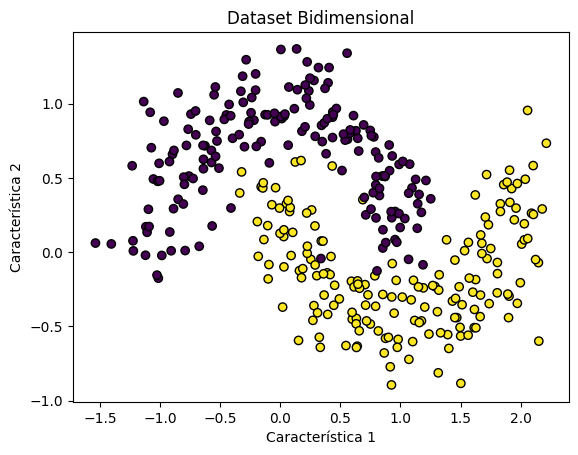

In [21]:
X, y = make_moons(n_samples=350, noise=0.20, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Dataset Bidimensional")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

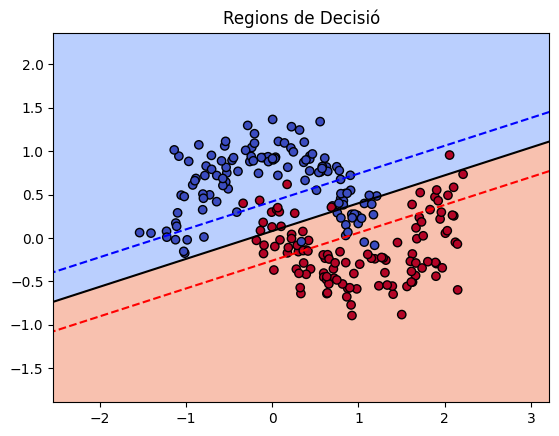

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(svm(kernel='linear'), param_grid, cv=5, scoring='accuracy')

# Executem la cerca
grid_search.fit(X_train, y_train)
plot_svm_decision_boundary(grid_search, X_train, y_train)

In [24]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        56
           1       0.87      0.78      0.82        60

    accuracy                           0.83       116
   macro avg       0.83      0.83      0.83       116
weighted avg       0.83      0.83      0.83       116



### SVM no lineal

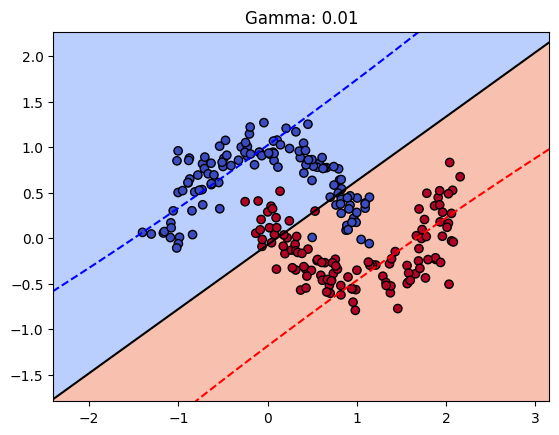

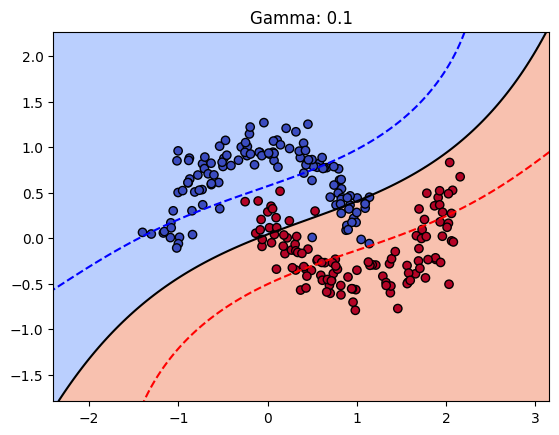

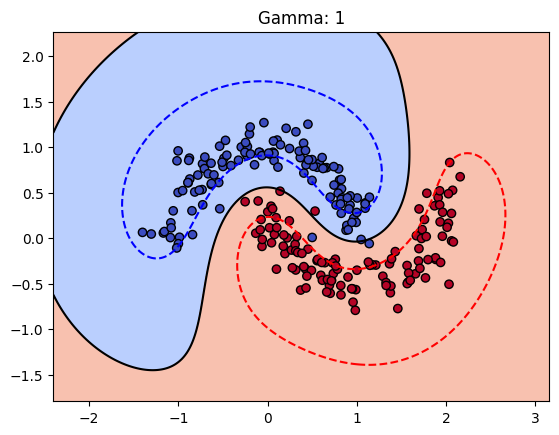

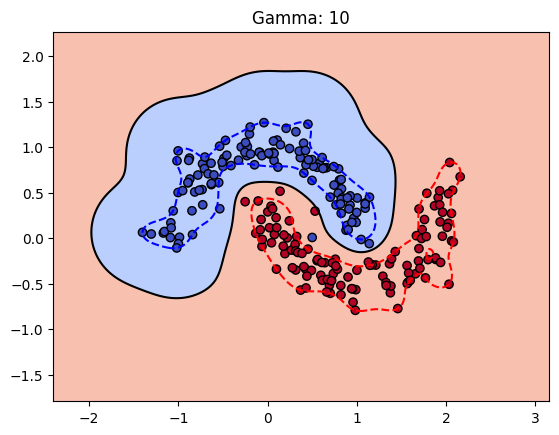

In [ ]:
gamma = [.01, .1, 1, 10]

for g in gamma:
    svc = svm(kernel='rbf', random_state=0, gamma=g, C=1)
    # Train the classifier
    svc.fit(X_train, y_train)

    # Visualize the decision boundaries
    plot_svm_decision_boundary(svc, X_train, y_train, f"Gamma: {g}")


# Executem la cerca


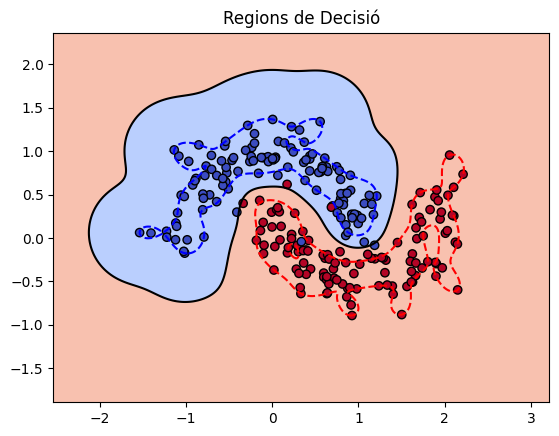

In [25]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(svm(kernel='rbf'), param_grid, cv=5, scoring='accuracy')

# Executem la cerca
grid_search.fit(X_train, y_train)
plot_svm_decision_boundary(grid_search, X_train, y_train)

In [26]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        56
           1       0.98      0.93      0.96        60

    accuracy                           0.96       116
   macro avg       0.96      0.96      0.96       116
weighted avg       0.96      0.96      0.96       116



# Feina a fer:

Emprant el conjunt de dades [ML Wine Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data), fer:
1. Entrenar tots els models de classificació vists fins ara (Perceptró, Regressió Logística, SVM Lineal i No lineal).
2. Emprar ``GridsearchCV`` per seleccionar els millors hiperparàmetres de cada model.
3. Compara els resultats entre els models.

**NOTA**. Aquest conjunt de dades el trobareu directament a ``scikit-learn``: [enllaç](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine).